In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
#We first get the data of TOI-762 A.
data = pd.read_csv('../../data/rvdata/TOI-762.csv')

data

bjd     rv  rv_err
0  2.458819e+06  47.93   11.30
1  2.458823e+06 -17.07   11.50
2  2.458837e+06 -29.07    8.70
3  2.458840e+06  19.93    5.80
4  2.458842e+06   4.93    6.40
5  2.459939e+06   3.43    7.14
6  2.459943e+06  39.13   10.60
7  2.459944e+06  40.13    8.42

In [7]:
#We define the time, velocity and the velocity error as arrays.
t = data.bjd.values
rv = data.rv.values
e_rv = data.rv_err.values

In [8]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafit
import gaiasource
reload(gaiafit)

gaiafit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafit' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiafit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/utils.py'>)

In [9]:
#We load the Prior file for our target.
f = '../../data/priors/TOI762_Priors.txt'
reload(gaiafit)

<module 'gaiafit' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiafit.py'>

In [10]:
#We then use "LPFunctionRVOnly2" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.
    #2 => Stands for 2 instruments.

#Note that LPFunctionRVOnly2 plots the Priors.
L = gaiafit.LPFunctionRVOnly(t,rv,e_rv,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafit.GaiaFitRVOnly(L)

Reading in priorfile from ../../data/priors/TOI762_Priors.txt
   prior          arg1          arg2        label  description priortype  \
0     NP  4.420000e-01  2.500000e-02        mstar        mstar     model   
1     UP  3.000000e-03  3.000000e-01           mp           mp     model   
2     NP  3.471683e+00  7.200000e-07         P_p1         P_p1     model   
3     NP  2.459850e+06  9.400000e-05        tp_p1        tp_p1     model   
4     UP  0.000000e+00  1.000000e-01       ecc_p1       ecc_p1     model   
5     UP  0.000000e+00  3.600000e+02     omega_p1     omega_p1     model   
6     NP  3.418000e-02  6.500000e-04         a_p1         a_p1     model   
7     UP  4.000000e+01  2.500000e+02         K_p1         K_p1     model   
8     UP  0.000000e+00  1.000000e+04        gamma        gamma     model   
9     UP  1.000000e-01  1.000000e+02     sigma_rv     sigma_rv     model   
10    FP  0.000000e+00  0.000000e+00     gammadot     gammadot     model   
11    FP  0.000000e+00  0.

In [11]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=2000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0     mstar  4.420000e-01  3.170000e-01  5.670000e-01  4.450769e-01 -3.076861e-03
1        mp  1.515000e-01  3.000000e-03  3.000000e-01  3.350729e-03  1.481493e-01
2      P_p1  3.471683e+00  3.471679e+00  3.471686e+00  3.471683e+00 -1.601073e-07
3     tp_p1  2.459850e+06  2.459850e+06  2.459850e+06  2.459850e+06  3.695022e-06
4    ecc_p1  5.000000e-02  0.000000e+00  1.000000e-01  9.874556e-02 -4.874556e-02
5  omega_p1  1.800000e+02  0.000000e+00  3.600000e+02  8.996158e+01  9.003842e+01
6      a_p1  3.418000e-02  3.093000e-02  3.743000e-02  3.417253e-02  7.473585e-06
7      K_p1  1.450000e+02  4.000000e+01  2.500000e+02  6.067931e+01  8.432069e+01
8     gamma  5.000000e+03  0.000000e+00  1.000000e+04  1.076007e+00  4.998924e+03
9  sigma_rv  5.005000e+01  1.000000e-01  1.000000e+02  1.107112e-01  4.993929e+01
LogPost value: -16.070030778125997
L

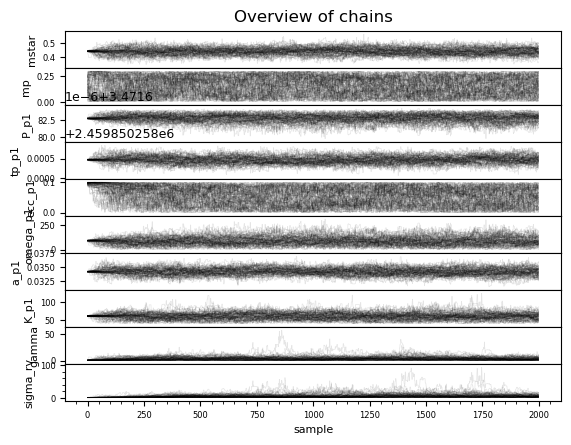

In [12]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [13]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

mstar        mp      P_p1         tp_p1    ecc_p1   omega_p1  \
0      0.471615  0.139689  3.471683  2.459850e+06  0.010617  55.258504   
1      0.471615  0.139689  3.471683  2.459850e+06  0.010617  55.258504   
2      0.474440  0.132219  3.471684  2.459850e+06  0.009413  18.183757   
3      0.474440  0.132219  3.471684  2.459850e+06  0.009413  18.183757   
4      0.474440  0.132219  3.471684  2.459850e+06  0.009413  18.183757   
...         ...       ...       ...           ...       ...        ...   
99995  0.423624  0.022539  3.471684  2.459850e+06  0.085238  23.694650   
99996  0.423624  0.022539  3.471684  2.459850e+06  0.085238  23.694650   
99997  0.423624  0.022539  3.471684  2.459850e+06  0.085238  23.694650   
99998  0.429203  0.050156  3.471684  2.459850e+06  0.086744  28.091381   
99999  0.429203  0.050156  3.471684  2.459850e+06  0.086744  28.091381   

           a_p1       K_p1     gamma  sigma_rv  
0      0.034127  51.921614  2.373953  8.352283  
1      0.034127  51.921614  2.373953  8.352283  
2      0.033975  48.880829  1.996789  9.603062  
3      0.033975  48.880829  1.996789  9.603062  
4      0.033975  48.880829  1.996789  9.603062  
...         ...        ...       ...       ...  
99995  0.034356  77.477641  2.258460  6.600774  
99996  0.034356  77.477641  2.258460  6.600774  
99997  0.034356  77.477641  2.258460  6.600774  
99998  0.034199  75.709679  2.897932  5.912734  
99999  0.034199  75.709679  2.897932  5.912734  

[100000 rows x 10 columns]

In [14]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                  values
0     mstar               $0.442_{-0.025}^{+0.026}$
0        mp                 $0.15_{-0.10}^{+0.098}$
0      P_p1   $3.4716828_{-0.0000006}^{+0.0000005}$
0     tp_p1  $2459850.258468_{-0.00009}^{+0.00010}$
0    ecc_p1               $0.054_{-0.035}^{+0.031}$
0  omega_p1                  $87.0_{-40.0}^{+47.0}$
0      a_p1         $0.03415_{-0.00064}^{+0.00068}$
0      K_p1                    $60.6_{-9.2}^{+9.3}$
0     gamma                     $3.3_{-2.2}^{+3.3}$
0  sigma_rv                     $4.2_{-3.0}^{+5.5}$

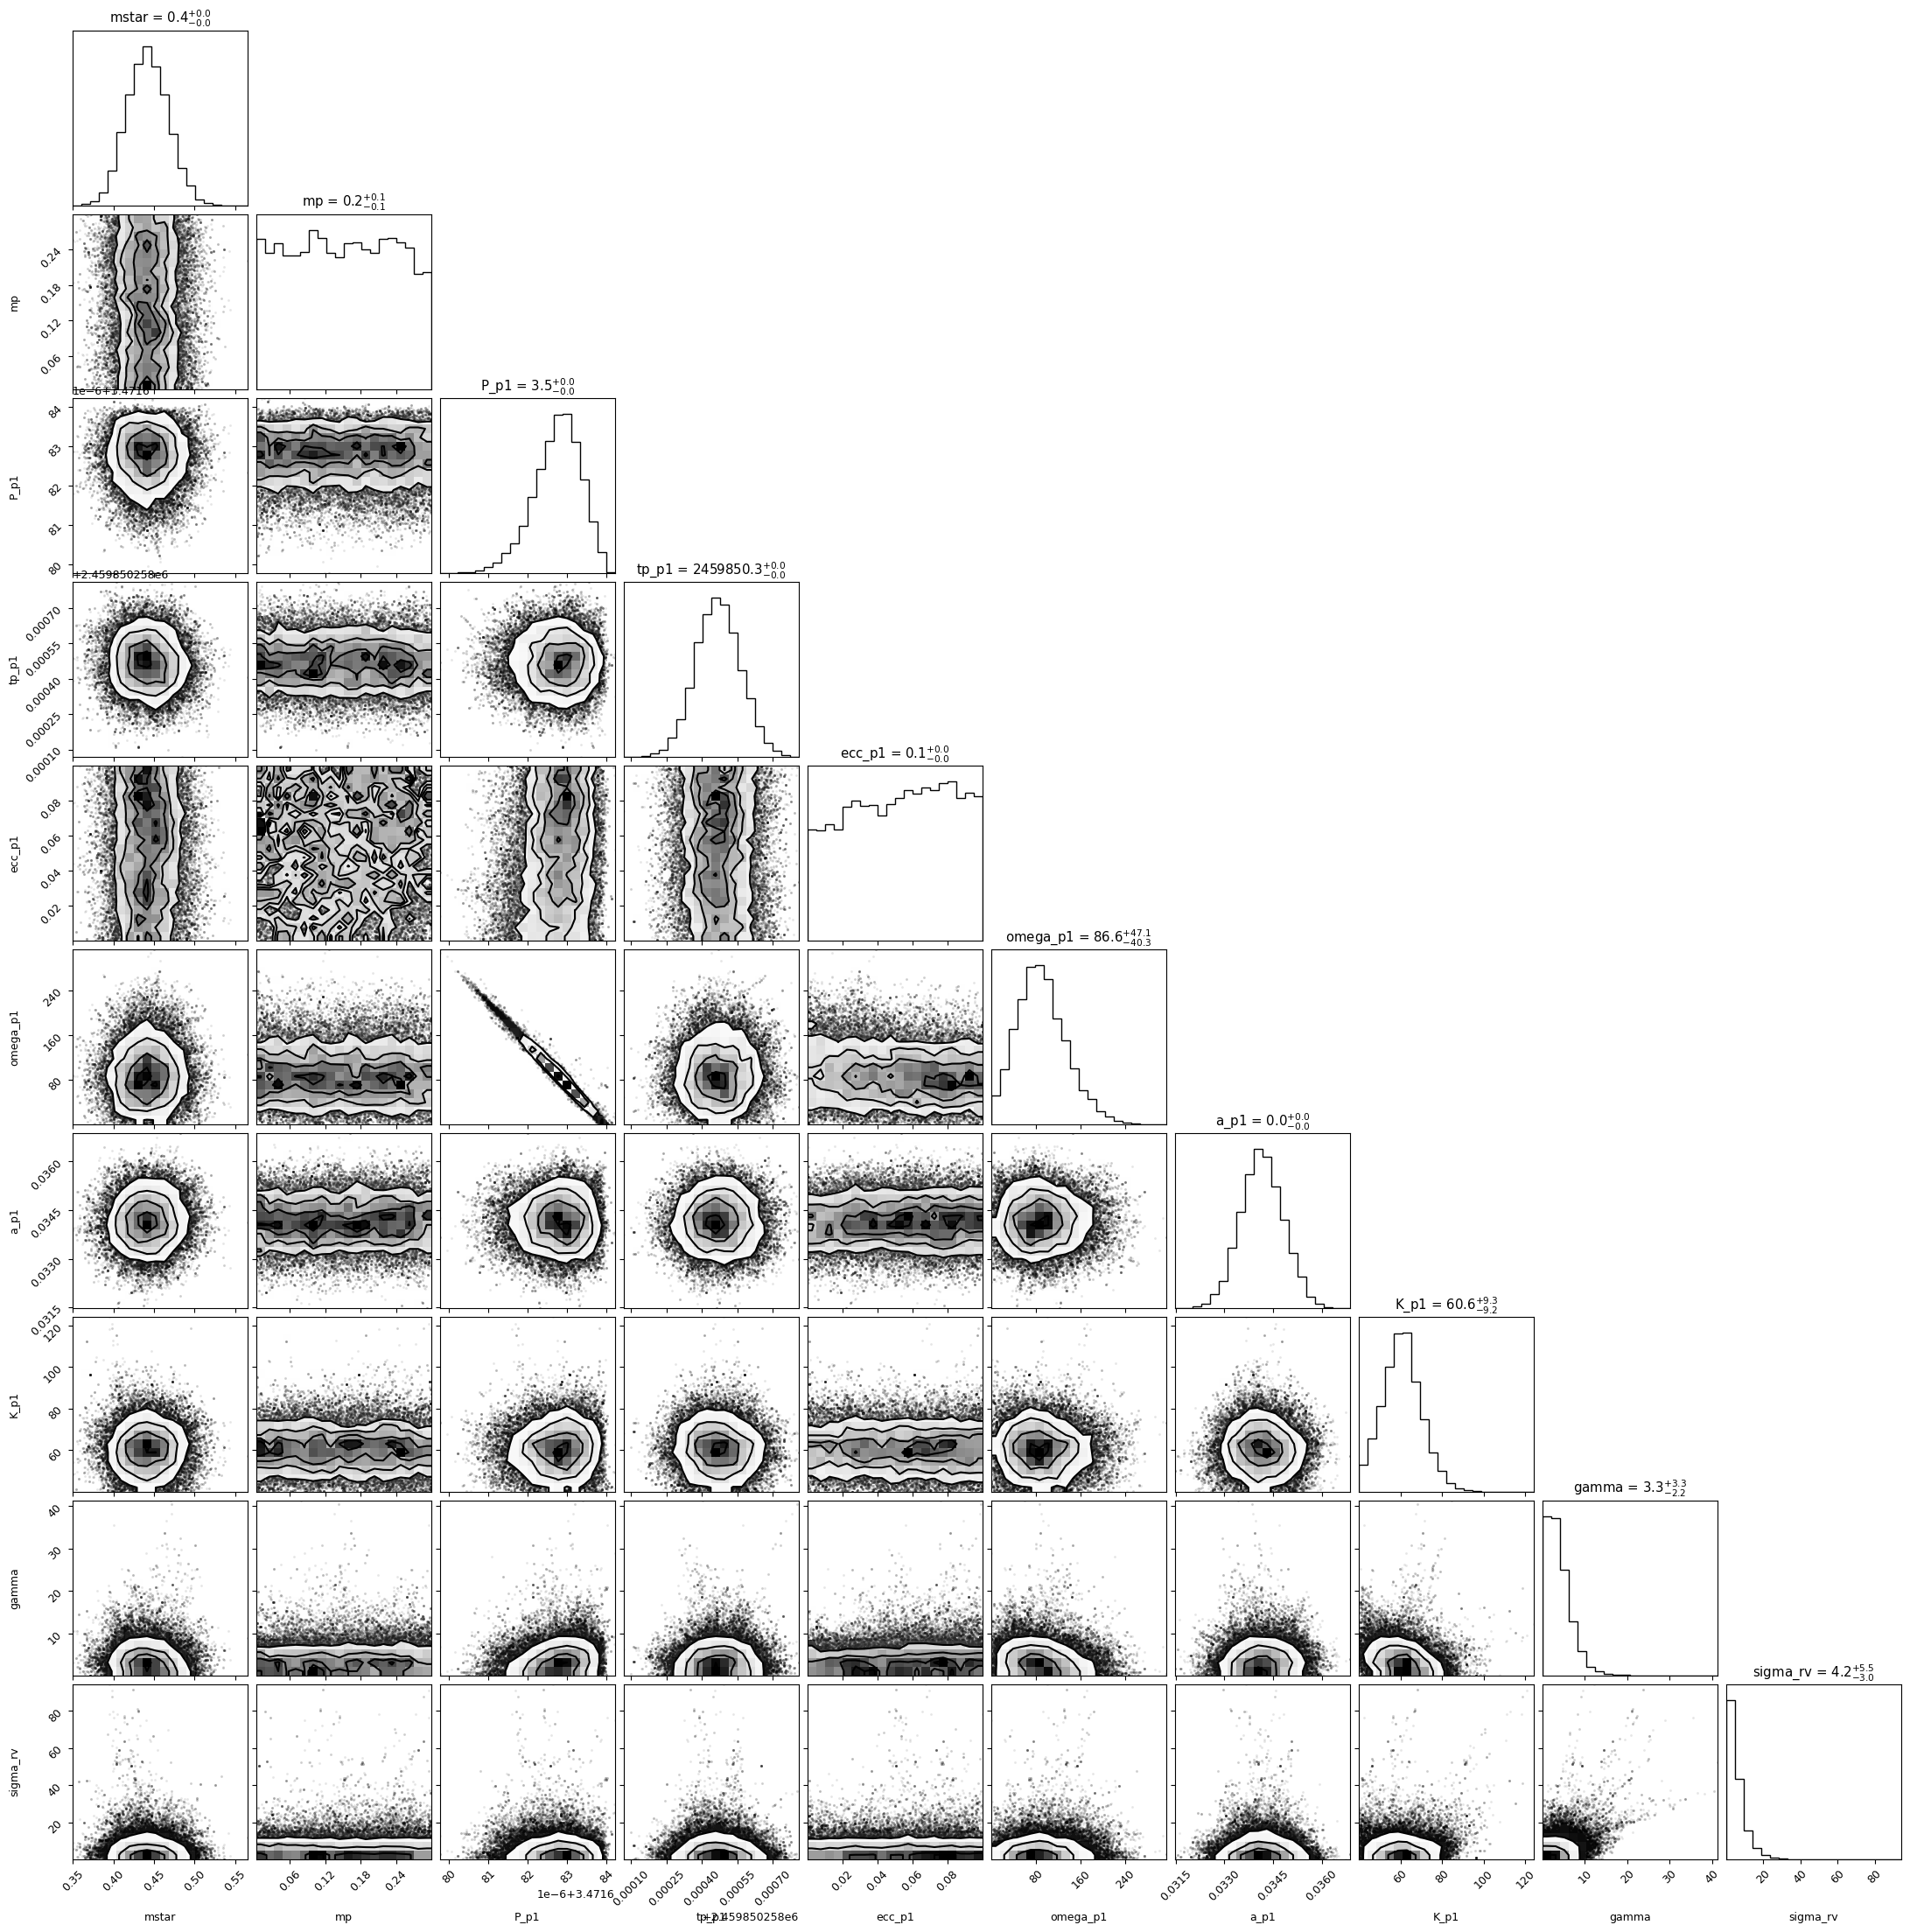

In [15]:
#We then plot the Corner Plot.
import corner
corner.corner(df_post.values,
       show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

plt.show();

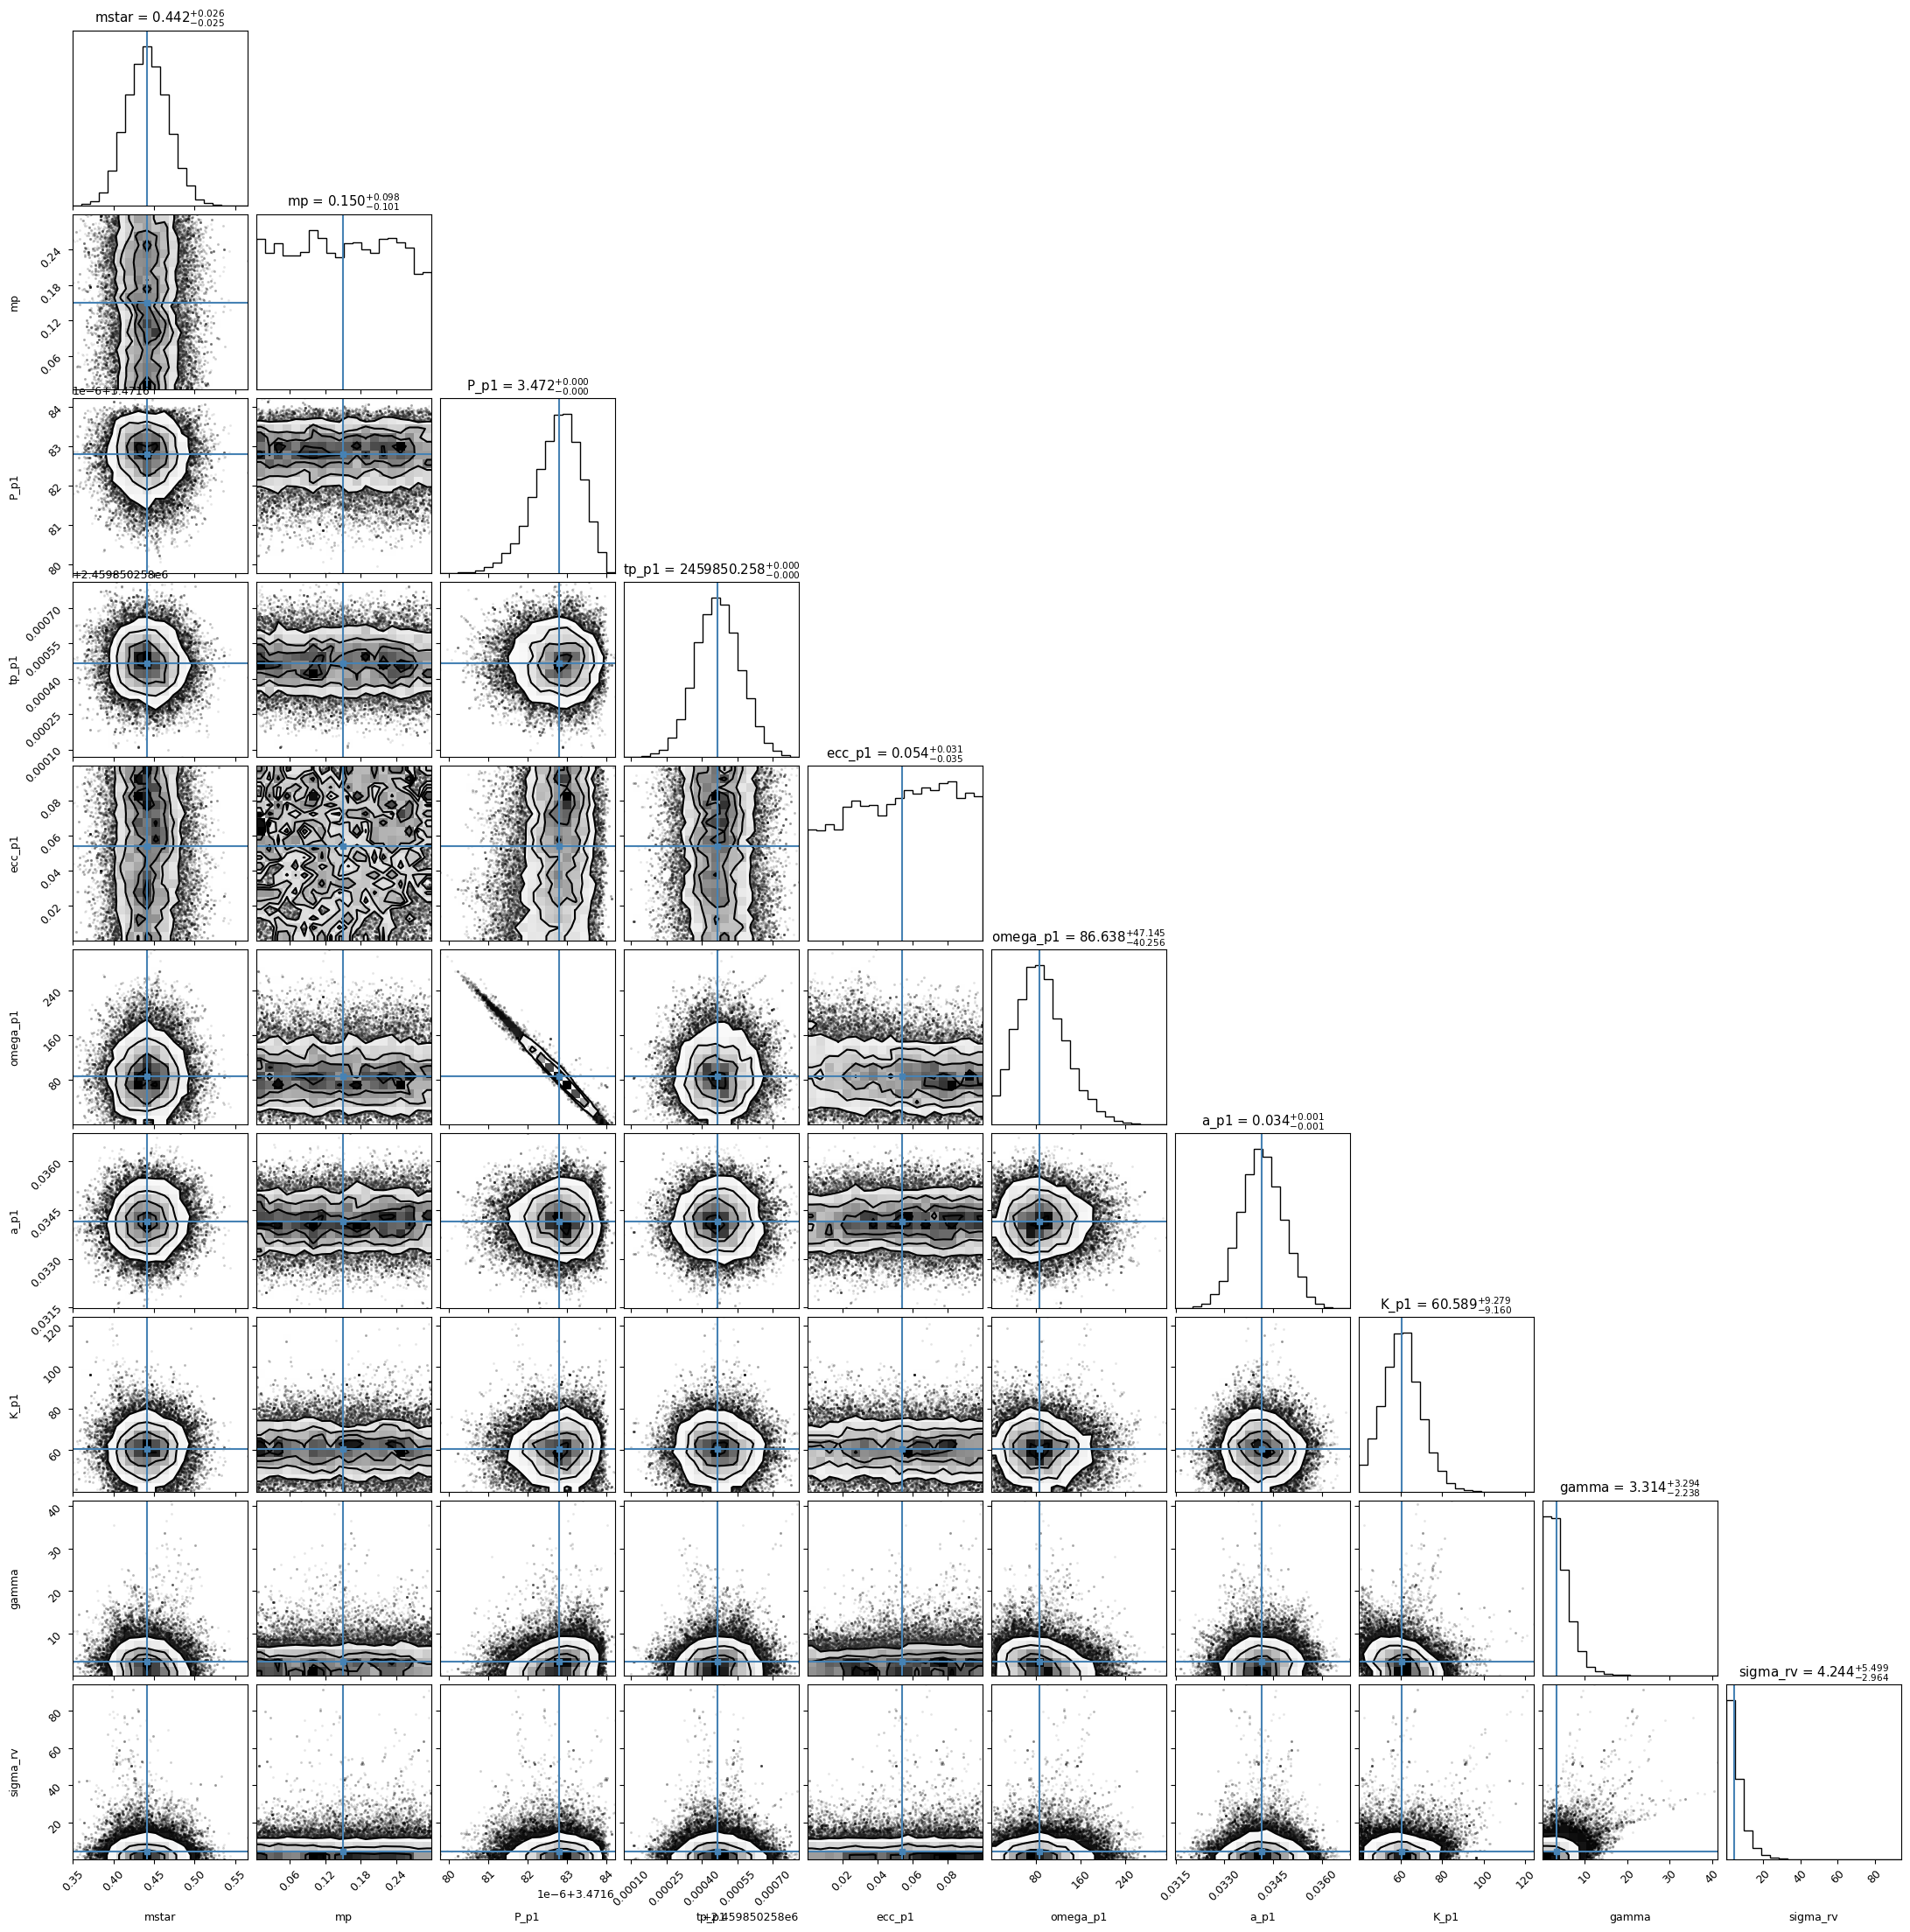

In [16]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.values,truths=pv_50,
       show_titles=True,labels=list(df_post.columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

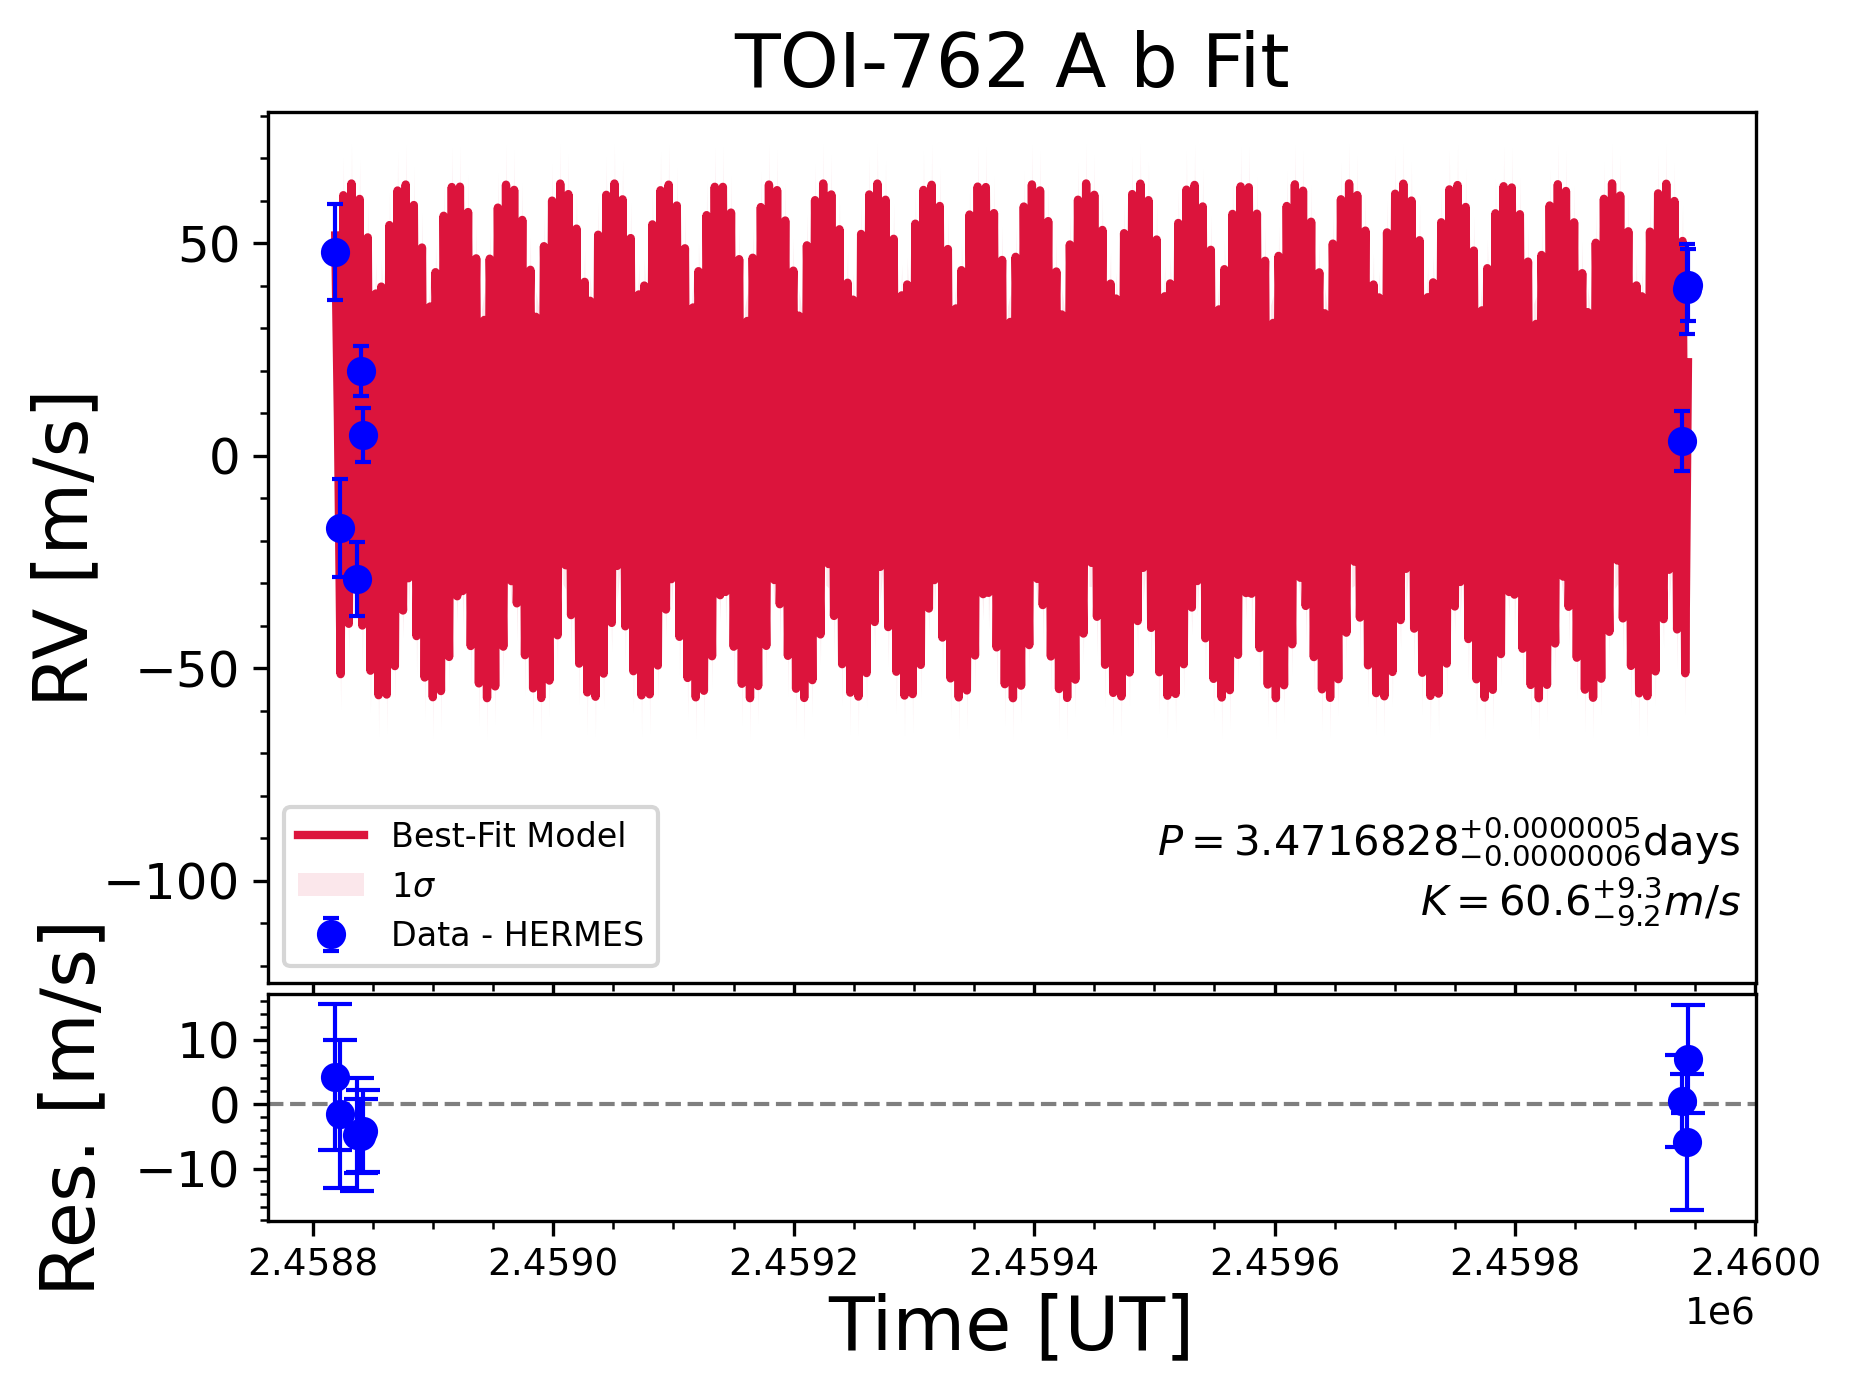

In [17]:
#We import astropy.time to convert Julian Dates into Datetimes i.e. the DD-MM-YYYY Format.
import astropy.time

#We define a function that turns Julian Dates into Datetime format.
def jd2datetime(times):
    return times
    #return np.array([astropy.time.Time(time,format="jd",scale="utc").datetime for time in times])

#We define the Title, Number of Models and the Shade color.
TITLE = 'TOI-762 A b Fit'
NUMMODELS = 5000
shadecolor="black"

###################
#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data['x'][0]-0.05,TF.lpf.data['x'][-1]+0.05,500)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.05,times1.max()+0.05,500)

#Our goal is to get the Residuals i.e. Data - Model.
#For that first we compute the Radial Velocities for both instruments using 50th percentiles i.e. the Model.
rv_501 = TF.lpf.compute_total_model(pv_50,t1_mod)

#Then we get the Radial Velocities for both instruments using the datafiles we have i.e. Data.
rv_50_obs1 = TF.lpf.compute_total_model(pv_50,TF.lpf.data['x'])

#We calculate the residuals.
res1 = TF.lpf.data['y'] - rv_50_obs1

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(dpi=300,nrows=2,gridspec_kw={'height_ratios': [5,1.3]},sharex=True)

#################
# Plot data
#################
#We first plot the Best-Fit Model.
#For that we first define a label.
label = r'Best-Fit Model'

#Then we also add the values of Period and Eccentricity into our label.
#Note that we are using "df_medvals" we found after MCMC.
#Note that we can also add Planet Mass and Inclination by removing "#" from the lines below.
lab = '$P=${}'.format(df_medvals[df_medvals.Labels=='P_p1']['values'].values[0])+'days\n'
#lab += r'$M_p=${}$M_E$'.format(earth_mass)+'\n'
#lab += r'$e=${}'.format(df_medvals[df_medvals.Labels=='ecc_p1']['values'].values[0])+'\n'
lab += r'$K=${}$m/s$'.format(df_medvals[df_medvals.Labels=='K_p1']['values'].values[0])+'\n'

#We define the marker color to be black for errorbars.
markercolor="blue"

#We define the errorbars & datapoints.
#Note that we put times into the jd2datetime function so that the dates turn from JD to Datetime.
ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color=markercolor,markersize=6,label='Data - HERMES')

#We finally also plot our model as follows.
ax.plot(jd2datetime(t1_mod),rv_501,color="crimson",label=label,lw=2.,zorder=-10)

#Now we work on the second Row for the Resiudal graph.
#We also need to plot the residuals with the error bars included.

#For that we define the errorbars & datapoints for the first dataset from first instrument.
bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color=markercolor,markersize=6)

#We add the values of our Parameters to the Bottom-Right of our first Graph i.e. RV Graph.
ax.text(0.99,0.01,lab,va='bottom',ha='right',fontsize=10,transform=ax.transAxes)

#We define a list to sample from our model, which we will use for Sigma Errors of our Fit.
mmodel1 = []
for i in range(NUMMODELS):
    #if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)

#We then show the 1-Sigma Error of our fit as follows.
#There are also options for 2-Sigma and 3-Sigma Errors, commented below.
ax.fill_between(jd2datetime(t1_mod),np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color='crimson',lw=0,label='1$\sigma$',zorder=-1)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-50, ylim[-1]+0)

#plt.savefig("toi_2431.png", dpi = 500)
plt.show();

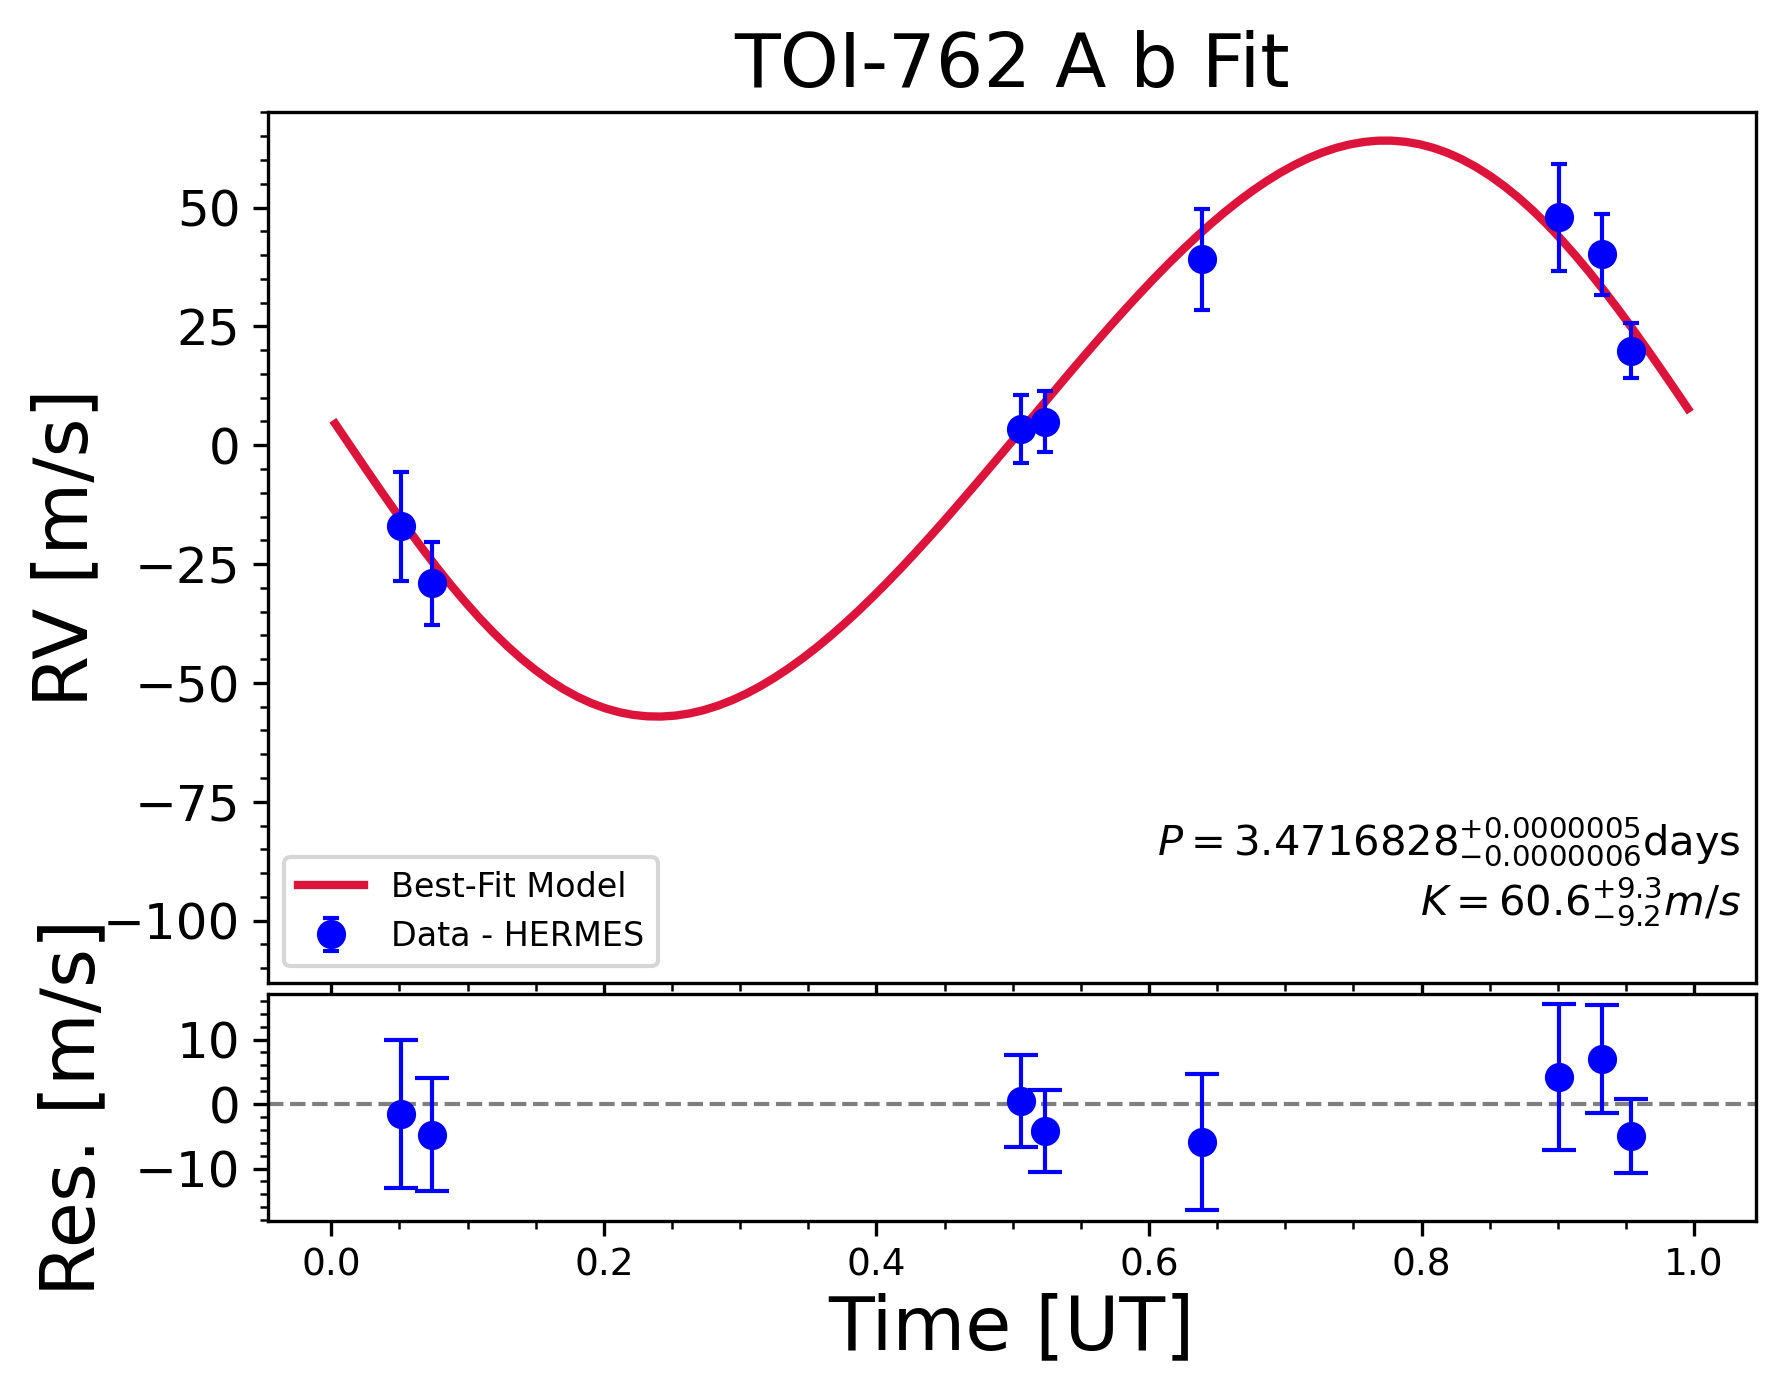

In [18]:
#We get the P and T0 values from the MCMC results.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "tp_p1"].values[0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0) % P) / P

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data['x'], P, T_0)

#We also convert the times for the model/fit to the orbital phases.
phase_model = time_to_phase(t1_mod, P, T_0)

#Now we define a figure again for our Phase Curve & Residuals.
fig, (ax, bx) = plt.subplots(dpi=300, nrows=2, gridspec_kw={'height_ratios': [5, 1.3]}, sharex=True)

#################
# Plot data
#################

#We first sort our data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_501_sorted = rv_501[sorted_indices]

#Then we plot the fit as follows.
label = r'Best-Fit Model'
ax.plot(phase_model_sorted, rv_501_sorted, color="crimson", label=label, lw=2., zorder=-10)

#We then plot our data around the fit as follows.
ax.errorbar(phase1, TF.lpf.data['y'], TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color=markercolor, markersize=6, label='Data - HERMES')

#We plot the residuals on the second row as follows.
res1 = TF.lpf.data['y'] - rv_50_obs1
bx.errorbar(phase1, res1, TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color=markercolor, markersize=6)

#We add the label for the fit parameters
ax.text(0.99, 0.01, lab, va='bottom', ha='right', fontsize=10, transform=ax.transAxes)

# For plotting the sigma errors (1-sigma range) - Does not work.
# mmodel1 = []
# for i in range(NUMMODELS):
#     idx = np.random.randint(0, flatchain.shape[0])
#     m1 = TF.lpf.compute_total_model(flatchain[idx], times=t1_mod)
#     mmodel1.append(m1)
# mmodel1 = np.array(mmodel1)

# # Plot 1-sigma error range
# ax.fill_between(phase_model, np.quantile(mmodel1, 0.16, axis=0), np.quantile(mmodel1, 0.84, axis=0),
#                 alpha=0.1, color='crimson', lw=0, label='1$\sigma$', zorder=-1)

#We add the legend and the labels.
ax.legend(loc='lower left', fontsize=8)
ax.set_ylabel('RV [m/s]', labelpad=0, fontsize=18)
bx.set_xlabel('Phase', labelpad=2, fontsize=18)
bx.set_ylabel('Res. [m/s]', labelpad=6, fontsize=18)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-50, ylim[-1]+0)

plt.show();